In [1]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Windows-11-10.0.22000-SP0


In [2]:
import tensorflow as tf
import os

tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    os.system("nvidia-smi")  # Correct way to run a shell command in Python

print("TensorFlow version " + tf.__version__)


TensorFlow version 2.18.0


In [3]:
MyDrive = '/kaggle/working'
PROJECT_DIR = './Downloads/violencedataset'

## **Preprocessing**
+ **Getting frames form video**
+ **some image argumentations**

In [4]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            # skipping frames to avoid duplications 
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

In [5]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')), 
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["NonViolence", "Violence"]
#700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:350])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
1000 Violence videos 
1000 NonViolence videos
i choose 700 videos out of 2000, cuz of memory issue


100%|██████████| 350/350 [03:46<00:00,  1.55it/s]

CPU times: total: 10min 11s
Wall time: 5min 10s


In [6]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

13979

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

## **Model Training**

In [8]:
!pip install imutils
clear_output()

In [9]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
# from keras.layers.core import Dropout,Flatten,Dense
from keras.layers import Dropout, Flatten, Dense

import matplotlib.pyplot as plt

In [10]:
# epochs = 50

# from keras import regularizers
# kernel_regularizer = regularizers.l2(0.0001)

# from keras.applications.mobilenet_v2 import MobileNetV2

# def load_layers():
#     input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
#     baseModel = MobileNetV2(pooling='avg',
#                             include_top=False, 
#                             input_tensor=input_tensor)
    
#     headModel = baseModel.output   
#     headModel = Dense(1, activation="sigmoid")(headModel)
#     model = Model(inputs=baseModel.input, outputs=headModel)

#     for layer in baseModel.layers:
#         layer.trainable = False

#     print("Compiling model...")
#     model.compile(loss="binary_crossentropy",
#                     optimizer='adam',
#                     metrics=["accuracy"])

#     return model

# if TPU_INIT:
#     with tpu_strategy.scope():
#         model = load_layers()
# else:
#     model = load_layers()

# model.summary()
epochs = 50

from keras import regularizers
from keras.layers import BatchNormalization, Dropout
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.optimizers import Adam

kernel_regularizer = regularizers.l2(0.0001)

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output  
    headModel = Dense(256, activation="relu")(headModel)  # Added dense layer
    headModel = BatchNormalization()(headModel)  # Batch normalization
    headModel = Dropout(0.5)(headModel)  # Dropout for regularization
    headModel = Dense(1, activation="sigmoid")(headModel)

    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False  # Freezing base model layers

    print("Compiling model...")
    optimizer = Adam(learning_rate=0.0001)  # Increased initial LR
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()


C:\Users\G_NIHARIKA\AppData\Local\Temp\ipykernel_2084\3986374707.py:46: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(pooling='avg',


Compiling model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,587,201 (9.87 MB)

 Trainable params: 328,705 (1.25 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [11]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

# start_lr = 0.00001
# min_lr = 0.00001
# max_lr = 0.00005
start_lr = 0.0001  # Increased initial LR
min_lr = 1e-6  # Ensuring a small but nonzero min LR
max_lr = 0.0001  # Keep max LR slightly higher


batch_size = 16

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

# def lrfn(epoch):
#     if epoch < rampup_epochs:
#         return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
#     elif epoch < rampup_epochs + sustain_epochs:
#         return max_lr
#     else:
#         return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
def lrfn(epoch):
    lr = 0.0001 * (0.95 ** epoch)  # Start with higher LR and decay gradually
    return max(lr, 1e-6)  # Ensure minimum LR

lr_callback = LearningRateScheduler(lrfn)



class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [12]:
end_callback = myCallback()

# lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)
lr_callback = LearningRateScheduler(lrfn, verbose=True)


# early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
#                                  mode='min', restore_best_weights=True, 
#                                  verbose = 1, min_delta = .00075)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

PROJECT_DIR = MyDrive + '/RiskDetection'

# lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)


os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

# checkpoint_filepath = 'ModelWeights.h5'
checkpoint_filepath = 'ModelWeights.weights.h5'


model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [13]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50


c:\Users\G_NIHARIKA\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


612/612 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7327 - loss: 0.5734
Epoch 1: val_loss improved from inf to 0.18959, saving model to ModelWeights.weights.h5
612/612 ━━━━━━━━━━━━━━━━━━━━ 87s 130ms/step - accuracy: 0.7328 - loss: 0.5731 - val_accuracy: 0.9292 - val_loss: 0.1896 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.5e-05.
Epoch 2/50
612/612 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9071 - loss: 0.2366
Epoch 2: val_loss improved from 0.18959 to 0.15777, saving model to ModelWeights.weights.h5
612/612 ━━━━━━━━━━━━━━━━━━━━ 75s 123ms/step - accuracy: 0.9071 - loss: 0.2366 - val_accuracy: 0.9406 - val_loss: 0.1578 - learning_rate: 9.5000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.025e-05.
Epoch 3/50
612/612 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9280 - loss: 0.1874
Epoch 3: val_loss improved from 0.15777 to 0.14373, saving model to ModelWeights.weights.h5
612/612 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - ac

In [14]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)                

------------------------------------------------------------------------------------------
Best Epochs:  9
Accuracy on train: 0.9810935258865356 	Loss on train: 0.06056050583720207
Accuracy on test: 0.968288004398346 	Loss on test: 0.08879420906305313


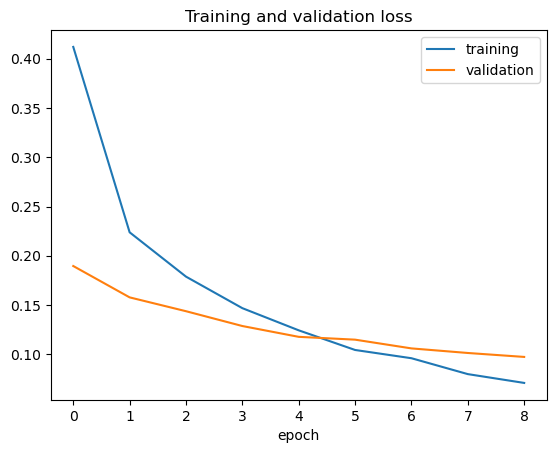

<Figure size 640x480 with 0 Axes>

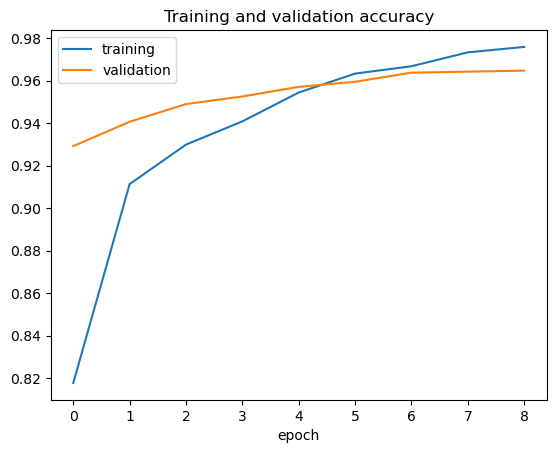

------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [15]:
model_summary(model, history)

## **Evaluation on test set**

In [16]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...


c:\Users\G_NIHARIKA\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step


c:\Users\G_NIHARIKA\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

c:\Users\G_NIHARIKA\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step
Classification Report:
               precision    recall  f1-score   support

 NonViolence       0.47      0.49      0.48      1778
    Violence       0.61      0.59      0.60      2416

    accuracy                           0.55      4194
   macro avg       0.54      0.54      0.54      4194
weighted avg       0.55      0.55      0.55      4194

Confusion Matrix:
 [[ 865  913]
 [ 985 1431]]


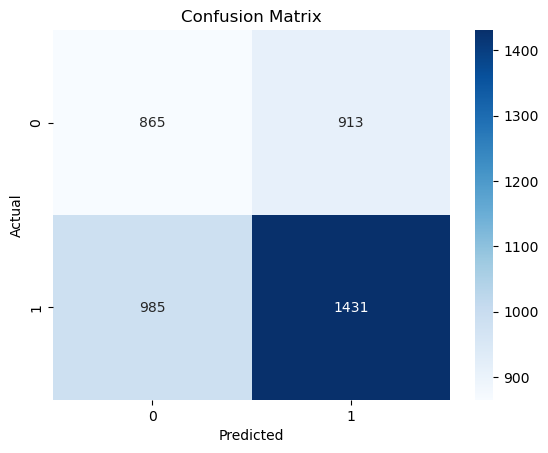

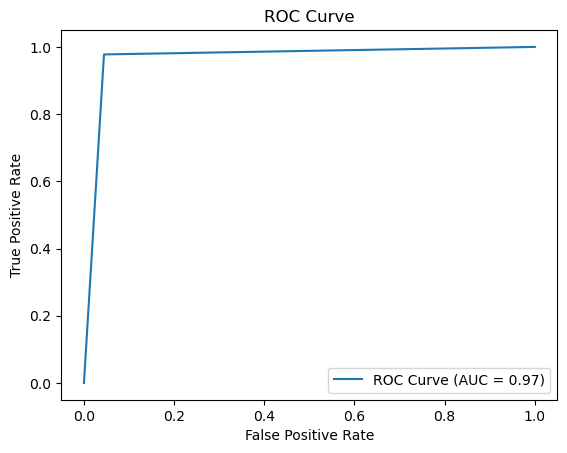

In [18]:
# import seaborn as sns
# from sklearn import metrics
# # from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
# from sklearn.metrics import RocCurveDisplay
# corr_pred = metrics.confusion_matrix(y_test, preds)

# n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
# print('> Correct Predictions:', n_correct)
# n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
# print('> Wrong Predictions:', n_wrongs)

# sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
# plt.show()

# print(metrics.classification_report(y_test, preds, 
#                            target_names=["NonViolence", "Violence"]))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix

# Assuming y_test and preds are defined
# # Convert model probabilities to binary predictions
X_test = X_test.reshape(-1, 128, 128, 3)
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to class labels

# Compute confusion matrix
corr_pred = confusion_matrix(y_test, y_pred)

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["NonViolence", "Violence"]))
print("Confusion Matrix:\n", corr_pred)

# Plot confusion matrix
sns.heatmap(corr_pred, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, preds)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, preds):.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [19]:
args_model = "D:/Violence-Alert-System/Violence Detection/modelnew.h5"
model.save(args_model)
